# Coursera IBM Applied Data Science Capstone: Final Assignment

Research question:

What are the 10 best municipalities in the Netherlands to build a new movie theater, based on the current placement of movie theaters?

In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
# !pip install geocoder
# !pip install geopy

import needed modules

In [3]:
import pandas as pd
pd.options.display.width = 200
# import geocoder # import geocoder
import geopy
import bs4
import requests
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# BeautifulSoup / Wikipedia --> get municipality information

make a BeautifulSoup instance to crawl a wikipedia page containing information on Dutch municipalities

In [4]:
url = r'https://nl.wikipedia.org/wiki/Tabel_van_Nederlandse_gemeenten'
r  = requests.get(url)
data = r.text
soup = bs4.BeautifulSoup(data, 'lxml')

scrape the wikipedia page into a pandas DataFrame

In [5]:
my_table = soup.find('table',{'class':'wikitable sortable'})
entries = my_table.find_all('td')

cols = ['Municipality', 'Province', 'Inhabitants', 'Total area', 'Land area', 'Inhabitants per square km', 'Average household income']
data_dict = {key: [] for key in cols}

it = iter(entries)

while True:
    for col in cols:
        entry = next(it, False)

        
        if not entry:
            break
        
        if not entry.contents:
            data_dict[col].append(np.nan)
            continue
            
#             data_dict[col].append(entry.contents[0].attrs['title'])
        try:
            val = entry.contents[0].string.strip(' \n').replace(",", "X").replace(".", "").replace("X", ".")
        except AttributeError:
            val = entry.contents[2].string.strip(' \n').replace(",", "X").replace(".", "").replace("X", ".")
    
        try:
            val = float(val)
        except ValueError:
            if not val:
                val = np.nan
    
        data_dict[col].append(val)

    else:
        continue
    
    break

df = pd.DataFrame(data_dict)
df = df[cols]
df[cols[2:]] = df[cols[2:]].astype(float) # float is needed later 

df['Average household income'] *= 1000 

print(df[:10])

          Municipality       Province  Inhabitants  Total area  Land area  Inhabitants per square km  Average household income
0          Aa en Hunze        Drenthe      25386.0      278.87     276.09                       92.0                   30700.0
1             Aalsmeer  Noord-Holland      31724.0       32.29      20.12                     1566.0                   34000.0
2               Aalten     Gelderland      27007.0       97.05      96.54                      279.0                   27800.0
3        Achtkarspelen      Friesland      27871.0      103.98     102.23                      273.0                   25500.0
4         Alblasserdam   Zuid-Holland      20060.0       10.06       8.78                     2280.0                   28800.0
5        Albrandswaard   Zuid-Holland      25292.0       23.76      21.69                     1163.0                   34400.0
6              Alkmaar  Noord-Holland     108578.0      117.35     110.46                      982.0           

# geopy --> get coordinates of municipalities

use geopy to lookup the latitude and longitude of each municipality

In [6]:
download_again = False
if download_again:
    geolocator = geopy.geocoders.Nominatim(user_agent="Coursera_Capstone_Final_Assignment")
    latitude_list = []
    longitude_list = []

    for ind, municipality in enumerate(df['Municipality']):
        print('{}: {}'.format(ind, municipality))
        location = geolocator.geocode(municipality)
        try:
            lat, long = location.latitude, location.longitude
        except AttributeError:
            lat, long = np.nan, np.nan

        latitude_list.append(lat)
        longitude_list.append(long)

    df['Latitude'] = latitude_list
    df['Longitude'] = longitude_list
    
    project.save_data(data=df.to_csv(index=False),file_name='Municipalities.csv',overwrite=True)

# https://medium.com/ibm-data-science-experience/control-your-dsx-projects-using-python-c69e13880312
else:
    df = pd.read_csv(project.get_file('Municipalities.csv'))
    print(df.head())

   Unnamed: 0   Municipality       Province  Inhabitants  Total area  Land area  Inhabitants per square km  Average household income   Latitude  Longitude
0           0    Aa en Hunze        Drenthe      25386.0      278.87     276.09                       92.0                   30700.0  52.981439   6.729452
1           1       Aalsmeer  Noord-Holland      31724.0       32.29      20.12                     1566.0                   34000.0  52.265834   4.766170
2           2         Aalten     Gelderland      27007.0       97.05      96.54                      279.0                   27800.0  51.928567   6.580902
3           3  Achtkarspelen      Friesland      27871.0      103.98     102.23                      273.0                   25500.0  53.207517   6.150764
4           4   Alblasserdam   Zuid-Holland      20060.0       10.06       8.78                     2280.0                   28800.0  51.859952   4.666202


exclude incorrect coordinates (will also exclude the Dutch Antilles)

In [7]:
df = df.loc[(df['Latitude'] > 50.7) & (df['Longitude'] < 8) & (df['Longitude'] > 3), :]

# Foursquare --> get all movie theaters in municipalities

use Foursquare to download all Movie Theaters near the longitudes/latitudes of the municipalities found above

set credentials

In [8]:
# The code was removed by Watson Studio for sharing.

define function to download all Movie Theaters

In [9]:
VERSION = '20190605' # Foursquare API version
LIMIT = 10000
radius = 10000
categoryID = '4bf58dd8d48988d17f941735' #Movie Theater
def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    
    venues_list=[]
    for ind, name, lat, lng in zip(range(len(names)), names, latitudes, longitudes):
        print(ind, name)
            
        url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&limit={}&intent=browse&radius={}'.format( 
            categoryID,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            LIMIT,            
            radius)

        # make the GET request
        response_json = requests.get(url).json()
        
        try:
            response = response_json["response"]['venues']
        except KeyError:
            print(response_json)
            raise
    
        #https://developer.foursquare.com/docs/api/venues/search
        
        # return only relevant information for each nearby venue
        venue_list = []
        
        for ind, v in enumerate(response):
            try:
                venue_list.append((
                    name, 
                    lat, 
                    lng, 
                    v['name'], 
                    v['location']['lat'], 
                    v['location']['lng'],
                    v['categories'][0]['name']))
            except IndexError:
                pass
        venues_list.append(venue_list)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Municipality', 
                  'Municipality Latitude', 
                  'Municipality Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

apply function and store result, or retrieve result from storage

In [10]:
download_venues_again = False
if download_venues_again:
    df_short = df
    df_venues = getNearbyVenues(names=df_short['Municipality'],
                                       latitudes=df_short['Latitude'],
                                       longitudes=df_short['Longitude']
                                      )
    project.save_data(data=df_venues.to_csv(index=False),file_name='Cinema.csv',overwrite=True)
else:
    df_venues = pd.read_csv(project.get_file('Cinema.csv'))

# Investigate data

the results for Amsterdam show that a Movie Theater is not well defined as it gives Movie Theaters, but also individual rooms (Zaal) and film festivals. Other cities even show movies shown.

In [11]:
print(df_venues.loc[df_venues['Municipality']=='Amsterdam'])

     Unnamed: 0 Municipality  Municipality Latitude  Municipality Longitude                      Venue  Venue Latitude  Venue Longitude       Venue Category
212         212    Amsterdam               52.37454                4.897976                Pathé Arena       52.312579         4.945553            Multiplex
213         213    Amsterdam               52.37454                4.897976                   De Balie       52.363209         4.883367                 Café
214         214    Amsterdam               52.37454                4.897976                        EYE       52.384139         4.900857               Museum
215         215    Amsterdam               52.37454                4.897976                  Kriterion       52.362555         4.910842  Indie Movie Theater
216         216    Amsterdam               52.37454                4.897976                      Pathé       52.366474         4.893252            Multiplex
217         217    Amsterdam               52.37454       

count the number of cinemas per municipality, but divide by a rough estimate of 10, and add the column to the dataframe

In [12]:
number_of_foursquare_cinemas_per_real_cinema = 10 # rough estimate
series_cinema = df_venues.groupby('Municipality').count()['Venue'].rename('Number of cinemas')/number_of_foursquare_cinemas_per_real_cinema
try:
    df.set_index('Municipality', inplace=True)
except KeyError:
    pass

df_merged = pd.concat([df, series_cinema], axis=1)
print(df_merged.head())

                  Unnamed: 0       Province  Inhabitants  Total area  Land area  Inhabitants per square km  Average household income   Latitude  Longitude  Number of cinemas
's-Hertogenbosch         136  Noord-Brabant     154231.0      118.07     110.25                     1392.0                   30100.0  51.709970   5.291916                2.8
Aa en Hunze                0        Drenthe      25386.0      278.87     276.09                       92.0                   30700.0  52.981439   6.729452                0.1
Aalsmeer                   1  Noord-Holland      31724.0       32.29      20.12                     1566.0                   34000.0  52.265834   4.766170                2.4
Aalten                     2     Gelderland      27007.0       97.05      96.54                      279.0                   27800.0  51.928567   6.580902                0.1
Achtkarspelen              3      Friesland      27871.0      103.98     102.23                      273.0                   25500

calculate parameters on which to base the recommendation of where to put a new cinema.

The parameter 'Number of potential customers for a new cinema' is viewed as follows:

To make life simple, it is assumed that people only go to one cinema and in their own municipality. Also, a new cinema doesn't lead to more potential customers in the municipality.

If a municipality has X inhabitants and Y cinemas, each cinema has X/Y customers. Now, a new cinema will potentially have X/(Y+1) customers.

In [13]:
df_merged['Number of cinemas per inhabitant'] = df_merged['Number of cinemas'] / df_merged['Inhabitants']
df_merged['Number of cinemas per square km'] = df_merged['Number of cinemas'] / df_merged['Land area']
df_merged['Number of cinemas per inhabitant times square km'] = df_merged['Number of cinemas'] / df_merged['Inhabitants'] * df_merged['Land area']
df_merged['Number of inhabitants per cinema'] = df_merged['Inhabitants'] / df_merged['Number of cinemas']
df_merged['Number of potential customers for a new cinema'] = df_merged['Inhabitants'] / (df_merged['Number of cinemas'] + 1)
df_merged.head()

,Unnamed: 0,Province,Inhabitants,Total area,Land area,Inhabitants per square km,Average household income,Latitude,Longitude,Number of cinemas,Number of cinemas per inhabitant,Number of cinemas per square km,Number of cinemas per inhabitant times square km,Number of inhabitants per cinema,Number of potential customers for a new cinema
's-Hertogenbosch,136,Noord-Brabant,154231.0,118.07,110.25,1392.0,30100.0,51.709970,5.291916,2.8,0.000018,0.025397,0.002002,55082.500000,40587.105263
Aa en Hunze,0,Drenthe,25386.0,278.87,276.09,92.0,30700.0,52.981439,6.729452,0.1,0.000004,0.000362,0.001088,253860.000000,23078.181818
Aalsmeer,1,Noord-Holland,31724.0,32.29,20.12,1566.0,34000.0,52.265834,4.766170,2.4,0.000076,0.119284,0.001522,13218.333333,9330.588235
Aalten,2,Gelderland,27007.0,97.05,96.54,279.0,27800.0,51.928567,6.580902,0.1,0.000004,0.001036,0.000357,270070.000000,24551.818182
Achtkarspelen,3,Friesland,27871.0,103.98,102.23,273.0,25500.0,53.207517,6.150764,0.1,0.000004,0.000978,0.000367,278710.000000,25337.272727


plot maps to get an idea of the geographical spread of important parameters

As expected, the Randstad is most densely populated, along with cities outside the Randstad.

Average household income is in general higher in the Randstad and Noord-Brabant.

Number of cinemas per inhabitant and per square km rougly follows average household income.

The expected number of customers for a new cinema is spread more evenly across the provinces of the Netherlands, but with local fluctuations within provinces.

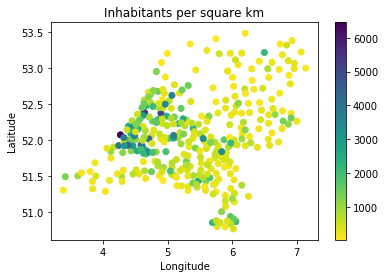

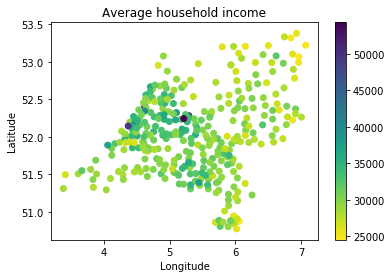

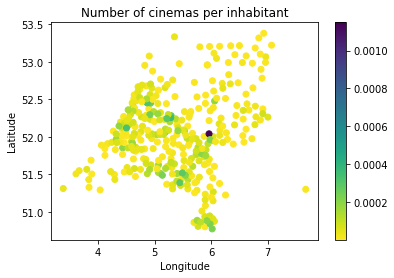

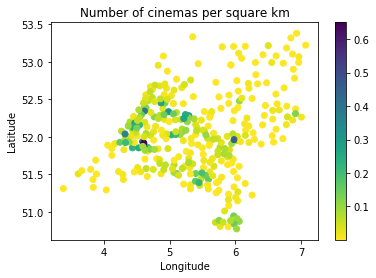

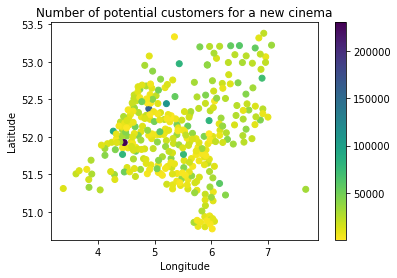

In [14]:
def plot_map(col):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(col)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    cm = plt.cm.get_cmap('viridis_r')
    im = ax.scatter(df_merged['Longitude'], df_merged['Latitude'], c=df_merged[col], cmap=cm)
    fig.colorbar(im, ax=ax)

plot_map('Inhabitants per square km')
plot_map('Average household income')
plot_map('Number of cinemas per inhabitant')
plot_map('Number of cinemas per square km')
plot_map('Number of potential customers for a new cinema')

plot same parameters against each other to see if there are obvious correlations.

The lack of correlation in Number of cinemas vs Inhabitants shows the not excellent quality of the Foursquare data. Besides the vague definition of a Movie Theater, the number of venues returned is also capped by Foursquare at 50. Divided by the factor 10, this gives the maximum value of 5 in the plot

There is some correlation between Number of cinemas per square km and Inhabitants per square km, but the wedge shape hints that this correlation is not so simple and another parameter may be at play.

The number of cinemas per inhabitant shows a small correlation with the average household income.

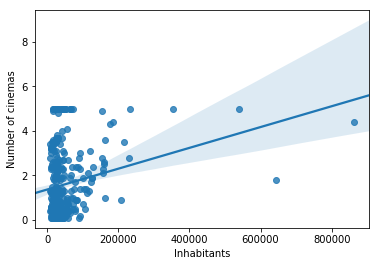

Inhabitants and Number of cinemas are correlated with R squared of 0.06


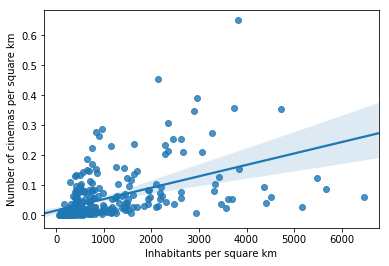

Inhabitants per square km and Number of cinemas per square km are correlated with R squared of 0.25


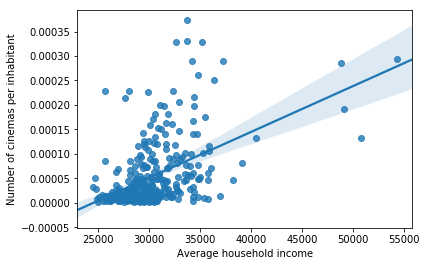

Average household income and Number of cinemas per inhabitant are correlated with R squared of 0.23


In [15]:
import seaborn as sns
import scipy.stats
def plot_xy(x, y):
    fig, ax =plt.subplots()
    df = df_merged.dropna()
    sns.regplot(x=x, y=y, data=df, ax=ax)
    plt.show()
    r2 = (scipy.stats.linregress(df[x], df[y])[2])**2
    print('{} and {} are correlated with R squared of {:.2f}'.format(x, y, r2))
    
plot_xy(x='Inhabitants', y='Number of cinemas')
plot_xy(x='Inhabitants per square km', y='Number of cinemas per square km')
plot_xy(x='Average household income', y='Number of cinemas per inhabitant')

# Apply machine learning

Divide the municipalities in clusters using K-means clustering, determine the number of clusters with the elbow method using the within-cluster sum of squares and with the silhoutte score.

Looking at the within-cluster sum of squares, I could not see a clear elbow.

The silhouette score (average distance of samples to closest neighbouring cluster) gives very high values for 2 clusters and more than 10 clusters. With 2 clusters it is clear that many points are far from the nearest neighbour and is not very descriptive. With more than 10 clusters, the clusters are so small, which makes them far from other clusters. Also, more than 10 clusters is difficult to work with.

A number of 8 clusters gives a (locally) high silhouette score and is descriptive enough.

['Unnamed: 0', 'Total area']
['Number of cinemas per inhabitant times square km', 'Number of inhabitants per cinema', 'Number of potential customers for a new cinema']


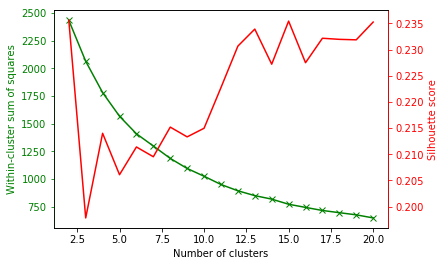

0
                            Province  Inhabitants  Average household income  Number of cinemas  Label
Aa en Hunze                  Drenthe      25386.0                   30700.0                0.1      0
Achtkarspelen              Friesland      27871.0                   25500.0                0.1      0
Almere                     Flevoland     207819.0                   28800.0                0.9      0
Apeldoorn                 Gelderland     162456.0                   29200.0                1.0      0
Appingedam     Groningen (provincie)      11713.0                   24900.0                0.1      0
Assen                        Drenthe      67970.0                   27200.0                1.3      0
Berkelland                Gelderland      43899.0                   28500.0                0.1      0
Borger-Odoorn                Drenthe      25359.0                   27900.0                0.2      0
Bronckhorst               Gelderland      36219.0                   31000.0     

In [16]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

import sklearn.cluster, sklearn.preprocessing, sklearn.metrics

dropped_column_list = ['Unnamed: 0', 'Total area']
                   
not_clustered_column_list = list(df_merged.columns.values)[-3:]
print(dropped_column_list)
print(not_clustered_column_list)


df_dropped = df_merged.dropna().drop(columns=dropped_column_list)
X = df_dropped.drop(columns=not_clustered_column_list) #drop(columns=['Number of cinemas', 'Number of cinemas per inhabitant', 'Number of cinemas per square km'])
X['Province'] = sklearn.preprocessing.LabelEncoder().fit_transform(X['Province'])
X_scaled = sklearn.preprocessing.StandardScaler().fit_transform(X)

def process_k_means(i_cluster, X_scaled):
    k_means = sklearn.cluster.KMeans(init="k-means++", n_clusters=i_cluster, n_init=10, random_state=3423)
    k_means.fit(X_scaled)
    cluster_labels = k_means.fit_predict(X_scaled)
    silhouette_avg = sklearn.metrics.silhouette_score(X_scaled, cluster_labels)
    return k_means, silhouette_avg
    

n_cluster_list = list(range(2, 21))
wcss_list = []
silhouette_score_list = []
for i_cluster in n_cluster_list:
    k_means, silhouette_avg = process_k_means(i_cluster, X_scaled)
    
    wcss_list.append(k_means.inertia_)
    silhouette_score_list.append(silhouette_avg)

    
fig, ax = plt.subplots()
ax.plot(n_cluster_list, wcss_list, 'gx-')
ax.set_ylabel('Within-cluster sum of squares')
ax.set_xlabel('Number of clusters')
ax.spines['left'].set_color('green')
ax.yaxis.label.set_color('green')
ax.tick_params(axis='y', colors='green')


ax2 = ax.twinx()
ax2.plot(n_cluster_list, silhouette_score_list, 'r')
ax2.set_ylabel('Silhouette score')
ax2.spines['right'].set_color('red')
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')

plt.show()

num_clusters = 8
k_means, _ = process_k_means(num_clusters, X_scaled)
    
df_clustered = df_dropped.copy()
df_clustered['Label'] = k_means.labels_


for label in range(num_clusters):
    print(label)
    print(df_clustered.loc[df_clustered['Label']==label, ['Province', 'Inhabitants', 'Average household income', 'Number of cinemas', 'Label']][0:10])

see how the clusters are distributed geographically and in number of cinemas and average household income

0. north, few cinemas, lower average household income
1. Randstad, some cinemas, lower average household income
2. east, few cinemas, lower average household income
3. scattered, many cinemas, high average household income
4. Randstad, few cinemas, lower average household income
5. big 4 cities, many cinemas, lower average household income
6. Randstad, many cinemas, above average average household income
7. center/south/east, many cinemas, lower average household income

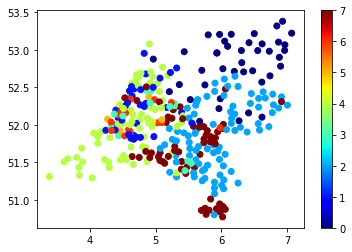

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
cm = plt.cm.get_cmap('jet')
im = ax.scatter(df_clustered['Longitude'], df_clustered['Latitude'], c=df_clustered['Label'], cmap=cm)
fig.colorbar(im, ax=ax)

look at the mean and standard deviation of the properties for the labels

In [29]:
df_labeled = df_clustered.groupby('Label').mean()
df_std = df_clustered.groupby('Label').std()
df_labeled['Std number of cinemas per inhabitant'] = df_std['Number of cinemas per inhabitant'].copy()
df_labeled['Std number of cinemas per square km'] = df_std['Number of cinemas per square km'].copy()
df_labeled['Std number of cinemas per inhabitant times square km'] = df_std['Number of cinemas per inhabitant times square km'].copy()
df_labeled.rename(columns={'Number of cinemas per inhabitant': 'Mean number of cinemas per inhabitant', 'Number of cinemas per square km': 'Mean number of cinemas per square km', 'Number of cinemas per inhabitant times square km': 'Mean number of cinemas per inhabitant times square km'}, inplace=True)
df_labeled['Count'] = df_clustered.groupby('Label').count()['Province']
print(df_labeled)
print(df_labeled.columns)
save_again = False
if save_again:
    project.save_data(data=df_labeled.to_csv(),file_name='Labeled.csv',overwrite=True)


         Inhabitants   Land area  Inhabitants per square km  Average household income   Latitude  Longitude  Number of cinemas  Mean number of cinemas per inhabitant  \
Label                                                                                                                                                                   
0       55968.463415  220.932439                 328.097561              28000.000000  52.807094   6.245530           0.558537                               0.000011   
1       67107.264706   27.509412                2596.205882              29464.705882  52.220868   4.758065           1.567647                               0.000030   
2       38205.811765   97.197412                 453.341176              29389.411765  51.851158   5.939179           0.671765                               0.000022   
3       16131.533333   27.512667                 643.000000              39013.333333  52.061347   4.962730           3.920000                             

show labels in correlations

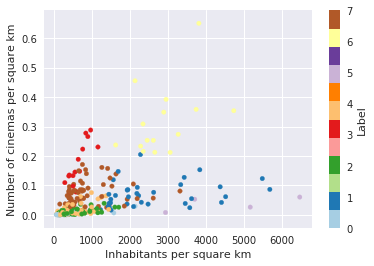

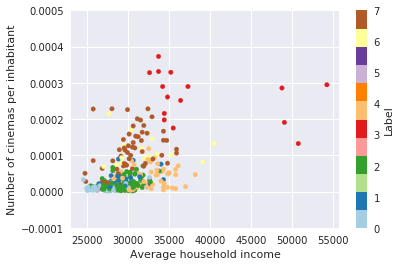

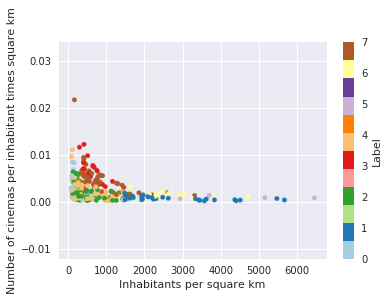

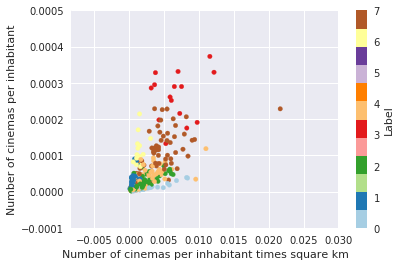

In [19]:
sns.set()
fig, ax = plt.subplots()
df_clustered.plot.scatter(x='Inhabitants per square km', y='Number of cinemas per square km', c='Label', cmap=plt.cm.get_cmap('Paired'), ax=ax)
fig, ax = plt.subplots()
df_clustered.plot.scatter(x='Average household income', y='Number of cinemas per inhabitant', c='Label', ylim=(-0.0001, 0.0005), cmap=plt.cm.get_cmap('Paired'), ax=ax)
fig, ax = plt.subplots()
df_clustered.plot.scatter(x='Inhabitants per square km', y='Number of cinemas per inhabitant times square km', c='Label', cmap=plt.cm.get_cmap('Paired'), ax=ax)
fig, ax = plt.subplots()
df_clustered.plot.scatter(x='Number of cinemas per inhabitant times square km', y='Number of cinemas per inhabitant', c='Label', ylim=(-0.0001, 0.0005), cmap=plt.cm.get_cmap('Paired'), ax=ax)

join dataframe with municipalities with dataframe with labels

In [20]:
label_columns = ['Mean number of cinemas per inhabitant',
       'Mean number of cinemas per square km',
       'Mean number of cinemas per inhabitant times square km',
       'Std number of cinemas per inhabitant',
       'Std number of cinemas per square km',
       'Std number of cinemas per inhabitant times square km']

df_final = df_clustered.join(df_labeled[label_columns], on='Label')


investigate which property is used to determine the best location to build a new cinema

Number of cinemas per inhabitant:
For a niche, you would want this to be as low as possible. If there are fewer cinemas now, they could use one. But, would you also get the most customers? This is not addressed.

Number of cinemas per square km:
For a niche, you would also want this to be as low as possible. If people have to travel far to reach a cinema, they could use one. But perhaps this is a sparsely populated area, and few potential customers live there?

Number of cinemas per inhabitant times square km:
Looking for densely populated areas with few cinemas gives a decent indication for the location of the next cinema. But it still doesn't guarantee if these municipalities have the largest number of potential customers.

In the histograms below, we can also see that these criteria give a lot of municipalities that are eligible. This makes it difficult to choose.

Simpler would be  to look at the potential number of customers more directly, as the number of inhabitants divided by the current number of cinemas + 1 (the new cinema). This also gives few municipalities to choose from.

The histograms of Inhabitants per square km and Average household income are given for completeness.

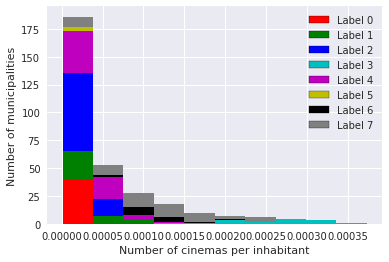

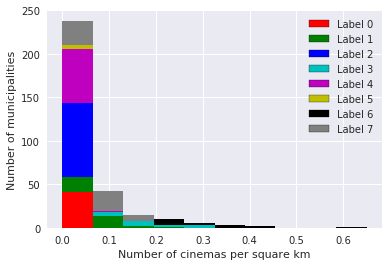

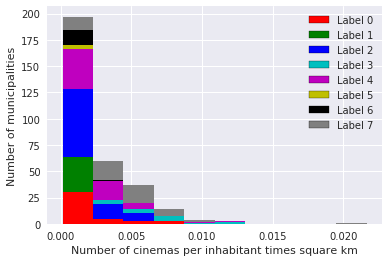

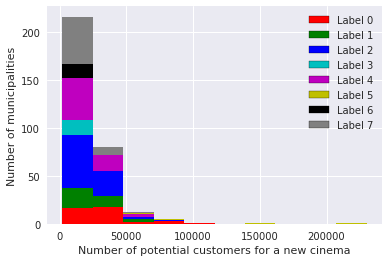

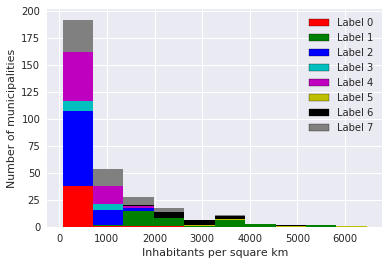

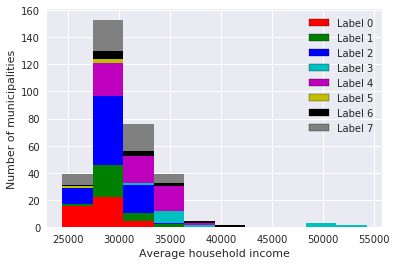

In [21]:
import matplotlib.patches

def plot_histogram(col):
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'grey']
    plt.hist([df_final.loc[df_final['Label'] == label, col].values for label in range(8)], stacked=True, color=colors)
    handles = [matplotlib.patches.Rectangle((0,0),1,1,color=c,ec="k") for c in colors]
    labels= ['Label {}'.format(label) for label in range(8)]
    plt.legend(handles, labels)
    plt.xlabel(col)
    plt.ylabel('Number of municipalities')
    plt.show()

plot_histogram('Number of cinemas per inhabitant') 
plot_histogram('Number of cinemas per square km')
plot_histogram('Number of cinemas per inhabitant times square km')
plot_histogram('Number of potential customers for a new cinema')
plot_histogram('Inhabitants per square km')
plot_histogram('Average household income')


# Results / discussion / conclusion

The 10 best municipalities to build a new cinema are:
1. Rotterdam 
2. Amsterdam 
3. Almere
4. Den Haag
5. Súdwest-Fryslân
6. Apeldoorn
7. Oss
8. Emmen
9. Groningen
10. Venlo

This seems to consist of two groups:
1. Large cities (Rotterdam, Amsterdam, Den Haag) which number of cinemas is suspiciously low (Rotterdam), low (Amsterdam), or capped by Foursquare (Den Haag)
2. Medium-sized cities with relatively few cinemas

One extra cinema in these municipalities can expect a lot of customers either because there are many people (group 1) or there are relatively few cinemas to compete with (group 2).

The top 10 only has labels 0, 5, and 2.
The top 50 does not have labels 3 and 6, which are both smaller municipalities with relatively many cinemas.

The usefulness of this result is seriously diminished by the low reliability of the Foursquare data. It goes beyond the scope of this course to improve that. Also, more reliable analysis could be done with data on a finer level than on municipal level only.

In [22]:
pd.options.display.max_rows = 100
df_final['Number of potential customers for a new cinema'] = df_final['Number of potential customers for a new cinema'].astype(int)
df_final['Inhabitants'] = df_final['Inhabitants'].astype(int)
print(df_final.loc[:, ['Number of potential customers for a new cinema', 'Inhabitants', 'Land area', 'Number of cinemas', 'Label']].sort_values('Number of potential customers for a new cinema', ascending=False))

                               Number of potential customers for a new cinema  Inhabitants  Land area  Number of cinemas  Label
Rotterdam                                                              230188       644527     217.57                1.8      5
Amsterdam                                                              159852       863202     165.50                4.4      5
Almere                                                                 109378       207819     129.19                0.9      0
Den Haag                                                                89664       537988      82.45                5.0      5
Súdwest-Fryslân                                                         81550        89705     522.26                0.1      0
Apeldoorn                                                               81228       162456     339.89                1.0      0
Oss                                                                     76197        91437     163.16   

In [28]:
save_again = False
if save_again:
    project.save_data(data=df_final.to_csv(),file_name='Final.csv',overwrite=True)
